In [1]:
# !git clone https://github.com/AxelThevenot/Python_Benchmark_Test_Optimization_Function_Single_Objective.git
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/src .
# !mv Python_Benchmark_Test_Optimization_Function_Single_Objective/pybenchfunction/ .
# !ls Python_Benchmark_Test_Optimization_Function_Single_Objective/

In [2]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pybenchfunction as bench
%matplotlib inline

In [3]:
# Functions with sum of terms structure

def LevyN13_i(i,x):
    w = 1.0+(x-1.0)/4.0
    if i==0:
        return  torch.sin(torch.pi*w[0])**2
    else:
        return  ( (w[i-1]-1)**2*(1+10*torch.sin(torch.pi*w[i-1]+1)**2)+ (w[-1]-1)**2*(1+torch.sin(2*torch.pi*w[-1])**2)         )

def PermDBeta_i(i,x):
    beta=0.5  # Added default value for beta
    v = 0
    d = x.size(dim=0)
    # j = np.arange(1, d+1)
    # j = range(1,d+1)
    # v = torch.sum(((j**(i+1) + beta) *((x/j)**(i+1) - 1))**2 ) 
    for j in range(d):
        # v+=(1+j+beta)*(x[j]**(i+1) -1. / (j+1)**(i+1))   
        # v+=(1+j+beta)*(x[j]/(j+1)**(i+1))  
        v+= ((((j+1)**(i+1) + beta) *((x[j]/(j+1))**(i+1) - 1))**2)/d 
    return v
    
def Rastrigin_i(i,x):
    v = 10+x[i]**2-10*torch.cos(2*torch.pi*x[i])
    return v
    
def RosenBrock_i(i,x):
    b = 100
    a = 1
    return b * (x[i] - x[i - 1] ** 2) ** 2 + (a - x[i]) ** 2   


In [4]:
from algorithms import *

In [5]:
font = {'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)
markers = {"SP2plus": "x", "SP2": "o", "SGD":"2" , "SP":"P", "Adam":"s", "Newton":"v"}
colours = {"SP2plus": "g", "SP2": "b", "SGD":"y" , "SP":"m", "Adam":"tab:pink", "Newton":"r"}

def plot_level_set_results(bench_function, results):
    bench.plot_2d(bench_function, n_space=100, ax=None, show=False)
    X_domain, Y_domain = bench_function.input_domain
    X_min, minimum = bench_function.get_global_minimum(2)
    plt.plot(X_min[0],X_min[1],'*', markersize=10, color='yellow')
    for key in results.keys():
        times, fvals, x_list =results[key]
        plt.scatter(x_list[0],x_list[1], s=20, label = key, zorder=1, color = colours[key], marker=markers[key])
    plt.xlim(X_domain)
    plt.ylim(Y_domain) 
    plt.tight_layout()
    plt.legend()
    plt.savefig(bench_function.name + '-2d.pdf', bbox_inches='tight', pad_inches =0)
    plt.show()
    bench.plot_3d(bench_function, n_space=100, ax=None, show=False)
    plt.plot(X_min[0],X_min[1],'*', markersize=12, color='yellow')
    
    for key in results.keys():
        times, fvals, x_list =results[key]
        plt.scatter(x_list[0],x_list[1], s=20, label = key, zorder=1, color = colours[key], marker=markers[key])
    plt.xlim(X_domain)
    plt.ylim(Y_domain) 
    plt.tight_layout()
    plt.savefig(bench_function.name + '-3d.pdf', bbox_inches='tight', pad_inches =0)
    plt.legend() 
    plt.show()


def plot_function_values(bench_function, results, timeplot = True, add_caption = None):
    linewidth =3
    for key in results.keys():
        time, fvals, x_list = results[key]
        try:
            plt.plot(fvals, colours[key] , label=key, linewidth=linewidth, markersize=10, marker = markers[key], markevery= int(np.floor(len(fvals)/5)))
        except:
            plt.plot(fvals, colours[key] , label=key, linewidth=linewidth, markersize=10, marker = markers[key])

    plt.ylabel('function value')
    plt.xlabel('epochs')
    plt.yscale('log')
    plt.legend()
    title = bench_function.name + '-funcs'
    if add_caption is not None:
        title = title + '-' + add_caption + '-'
    plt.savefig(title +  '.pdf',bbox_inches='tight', pad_inches =0)
    plt.show()

    if timeplot:
        for key in results.keys():
            time, fvals, x_list = results[key]
            if key == "Newton":
                continue
            plt.plot(time*np.arange(len(fvals)), fvals, colours[key] , label=key, linewidth=linewidth, markersize=10, marker = markers[key], markevery= int(np.floor(len(fvals)/5)))
        plt.ylabel('function value')
        plt.xlabel('time')
        plt.yscale('log')
        plt.legend()
        plt.ticklabel_format(style='sci', axis = 'x', scilimits = (0,5))
        plt.savefig(title +  '-time.pdf',bbox_inches='tight', pad_inches =0)
        plt.show()

In [6]:
import time

def run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = None, adam_step = 0.01, running_newton = True):
    t0 = time.perf_counter()
    SP2plus_x_list, SP2plus_fval  =run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    SP2plus_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    SP2_x_list, SP2_fval  =run_SP2(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    SP2_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    SGD_x_list, SGD_fval  =run_SGD(fi, epochs=epochs, x0 = x0,d=d, lr=sgd_step)
    SGD_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    if running_newton:
        newt_x_list, newt_fval=run_newton(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize)
    else:
        newt_x_list =0; newt_fval =0
    newt_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    SP_x_list, SP_fval=run_SP2plus(fi, epochs=epochs, x0 = x0, d=d, lr=stepsize, nosp1=False)
    SP_time = time.perf_counter() -t0
    t0 = time.perf_counter()
    Adam_x_list, Adam_fval=adam(fi, epochs=epochs, x0 = x0, d=d, lr=adam_step )
    Adam_time = time.perf_counter() -t0
    results = {"SP2plus": (SP2plus_time, SP2plus_fval, SP2plus_x_list), 
                "SP2": (SP2_time, SP2_fval, SP2_x_list), 
                "SGD": (SGD_time, SGD_fval, SGD_x_list), 
                "SP": (SP_time, SP_fval, SP_x_list), 
                "Adam": (Adam_time, Adam_fval, Adam_x_list), 
                "Newton": (newt_time, newt_fval, newt_x_list),   }
    return results #fvals, times, xvals
    
def run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = None, adam_step = 0.01):
    if sgd_step is None:
        sgd_step = stepsize
    if adam_step is None:
        adam_step = stepsize
    results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step)
    plot_function_values(ffull, results)
    plot_level_set_results(ffull, results ) 

In [7]:
# Global stepsize for methods except SGD (which required tuning)
stepsize= 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

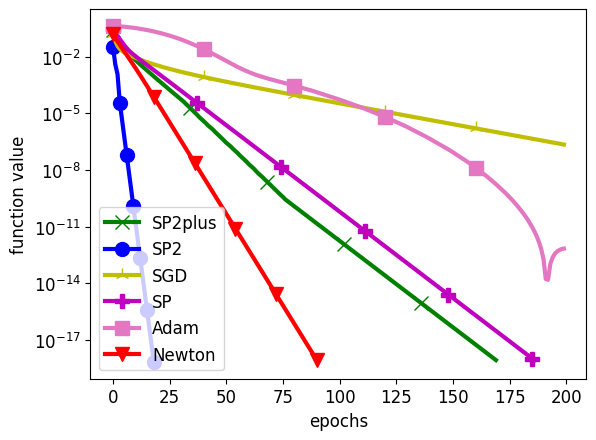

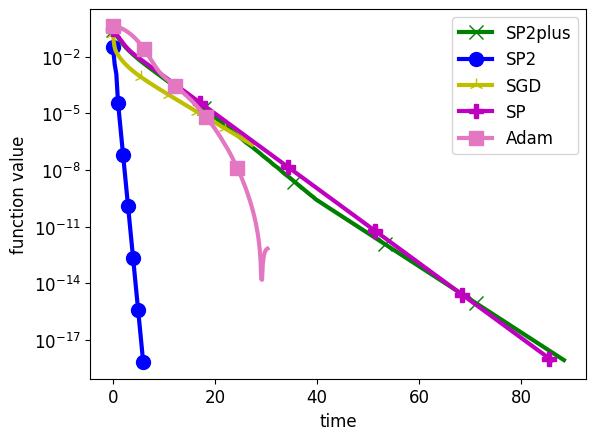

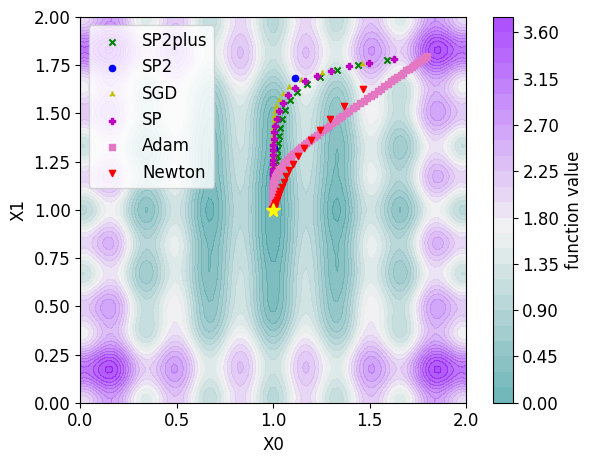

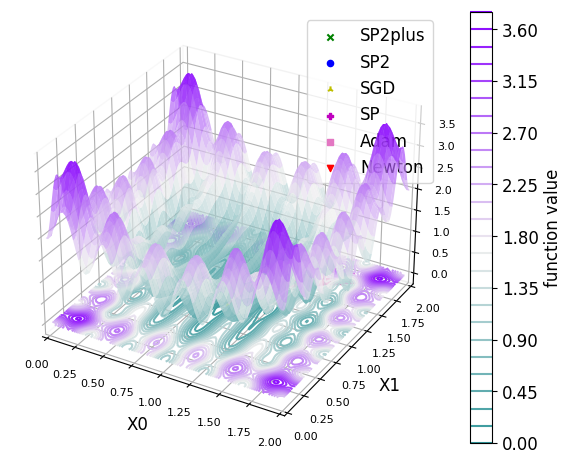

In [8]:
d=2
epochs = 200
x0 = torch.ones(d, requires_grad=True).double() *1.8
fi = LevyN13_i
ffull  = bench.function.LevyN13(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = stepsize, adam_step=0.05) #, 


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

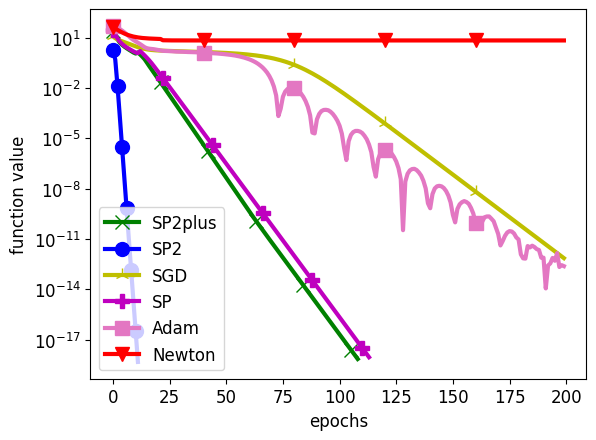

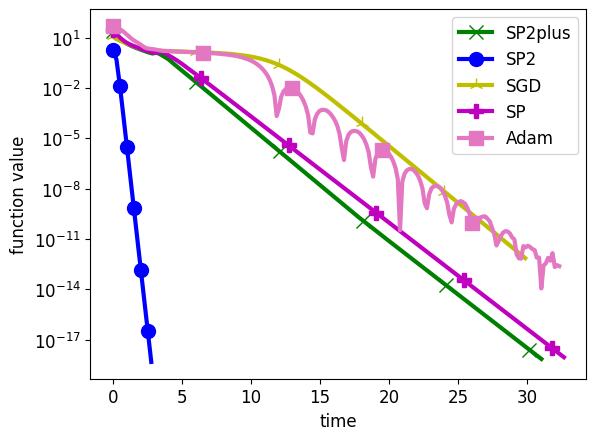

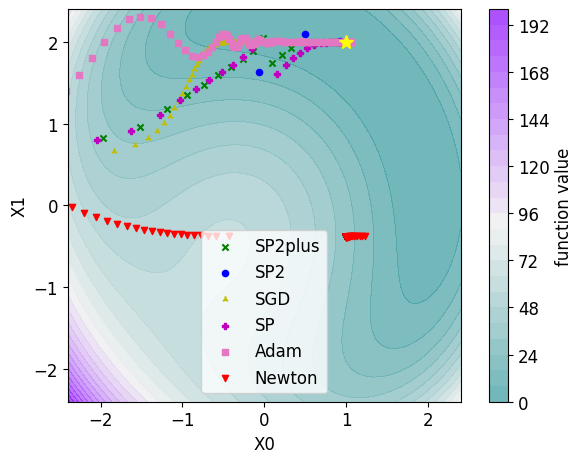

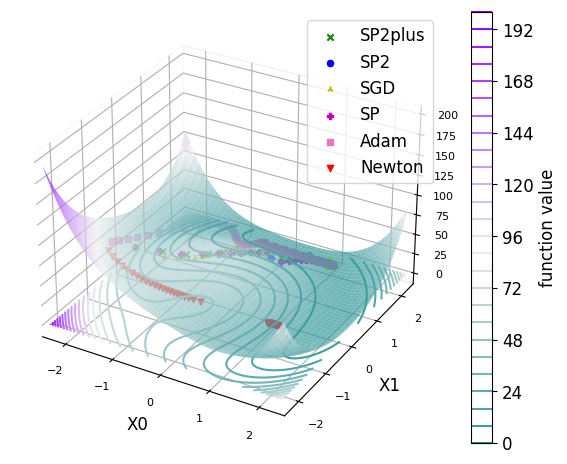

In [9]:

d=2
epochs = 200
x0 = -2*torch.randn(d, requires_grad=True).double()
fi = PermDBeta_i
ffull  = bench.function.PermDBeta(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = 0.01, adam_step=1.0)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

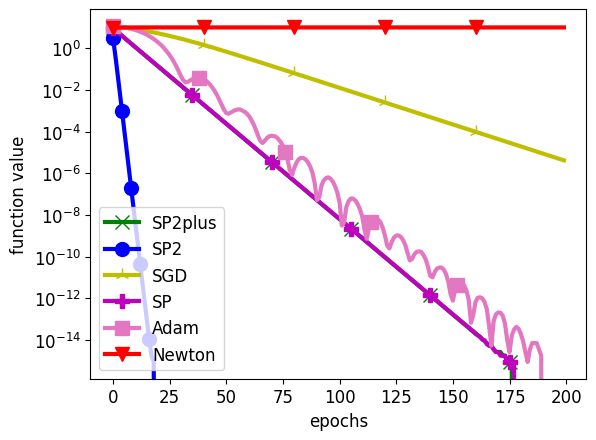

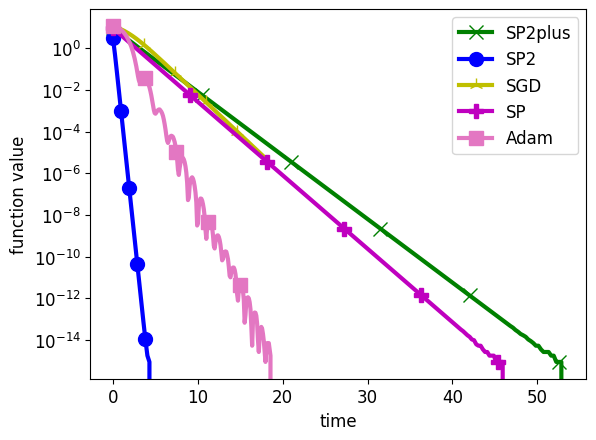

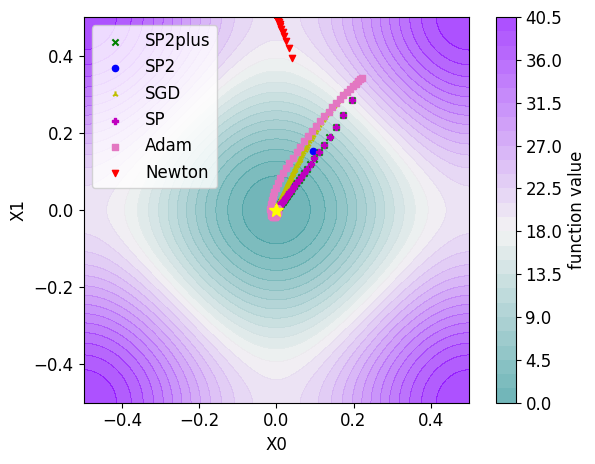

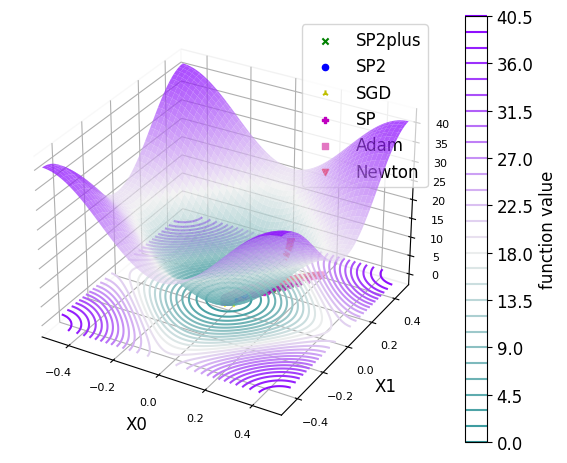

In [10]:
d=2
epochs = 200
x0 = torch.rand(d, requires_grad=True).double() *0.45
fi = Rastrigin_i
ffull  = bench.function.Rastrigin(d)
run_plot_all(fi,ffull, epochs, stepsize,x0,d, sgd_step = 0.0001, adam_step=0.05)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

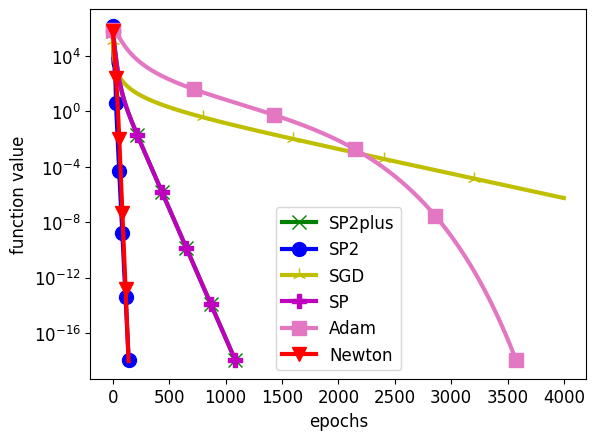

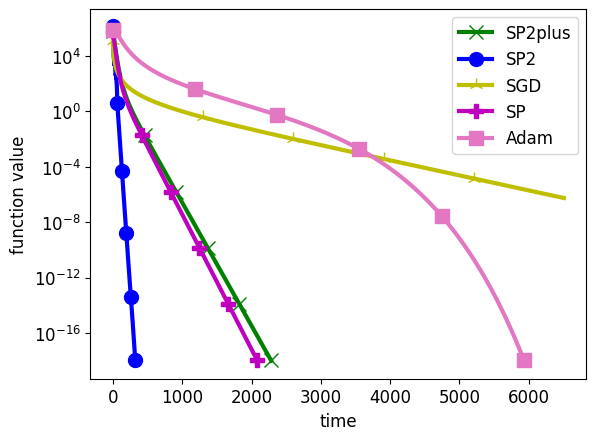

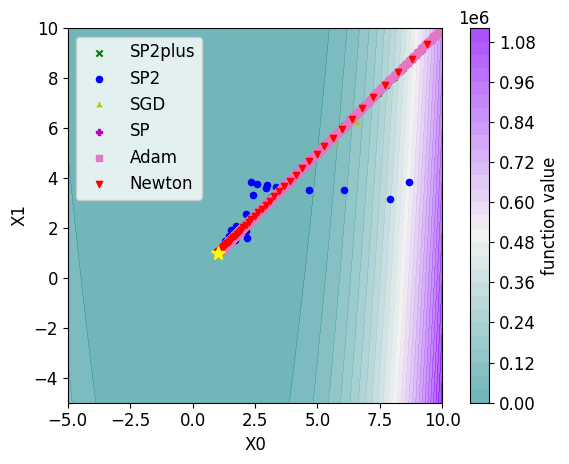

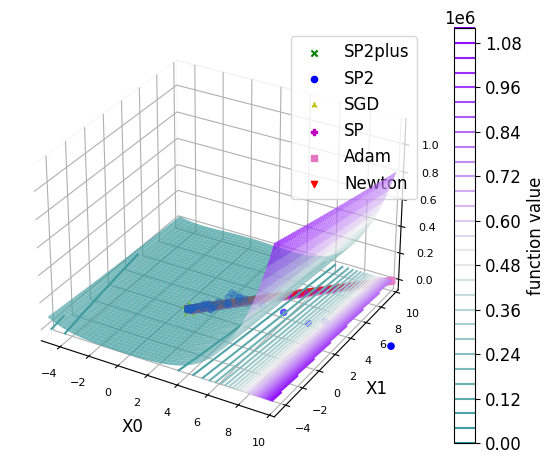

In [11]:
d=2
epochs = 4000
x0 = torch.ones(d, requires_grad=True).double()*10
fi = RosenBrock_i
ffull  = bench.function.Rosenbrock(d)
rosenstep = stepsize #/3
run_plot_all(fi,ffull, epochs, rosenstep, x0,d, sgd_step = 0.00001, adam_step=stepsize)


In [12]:
d = 10
stepsize = 0.005
sgd_step = 0.0000000001
adam_step = 0.1
epochs = 4000
x0 = -2*torch.randn(d, requires_grad=True).double()
fi = PermDBeta_i
ffull  = bench.function.PermDBeta(d)
results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step, running_newton = False)
plot_function_values(ffull, results, add_caption = str(d))

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
d = 10
stepsize = 0.005
sgd_step = 0.0000000001
adam_step = 0.1
epochs = 40
x0 = -2*torch.randn(d, requires_grad=True).double()
fi = PermDBeta_i
ffull  = bench.function.PermDBeta(d)
results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step, running_newton = False)
plot_function_values(ffull, results, add_caption = str(d))

In [ ]:
d =100
stepsize = 0.5
sgd_step = 0.005
adam_step = 0.001
epochs = 1000
x0 = torch.rand(d, requires_grad=True).double() *0.45
fi = Rastrigin_i
ffull  = bench.function.Rastrigin(d)
results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step, running_newton = False)
plot_function_values(ffull, results, add_caption = str(d))

In [ ]:
d= 100
stepsize = 0.1
sgd_step = 0.00001
adam_step = 0.01
epochs = 5000
x0 = torch.ones(d, requires_grad=True).double()*10
fi = RosenBrock_i
ffull  = bench.function.Rosenbrock(d)
results = run_all_method(fi,ffull, epochs, stepsize,x0,d, sgd_step = sgd_step, adam_step = adam_step, running_newton = False)
plot_function_values(ffull, results, add_caption = str(d))